<a href="https://colab.research.google.com/github/UtkarshRaj130/Advanced_Soybean_Agricultural_Dataset_Analysis/blob/main/Code_Notebooks/06_clustering_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!wget https://raw.githubusercontent.com/UtkarshRaj130/Advanced_Soybean_Agricultural_Dataset_Analysis/refs/heads/main/Dataset/3_direct_encoded.csv -O 3_direct_encoded.csv

--2025-04-11 19:35:20--  https://raw.githubusercontent.com/UtkarshRaj130/Advanced_Soybean_Agricultural_Dataset_Analysis/refs/heads/main/Dataset/3_direct_encoded.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9093 (8.9K) [text/plain]
Saving to: ‘3_direct_encoded.csv’

3_direct_encoded.cs 100%[===================>]   8.88K  --.-KB/s    in 0.001s  

2025-04-11 19:35:21 (6.07 MB/s) - ‘3_direct_encoded.csv’ saved [9093/9093]



#For dataset 3_direct_encoded.csv

In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
# Load cleaned + encoded data
full_data = pd.read_csv("3_direct_encoded.csv")
data_v2 = full_data.iloc[:, 2:]

# Standardize
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data_v2), columns=data_v2.columns)

# PCA
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(scaled_data), columns=["PC1", "PC2"])


Silhouette Score (K=5): 0.3851


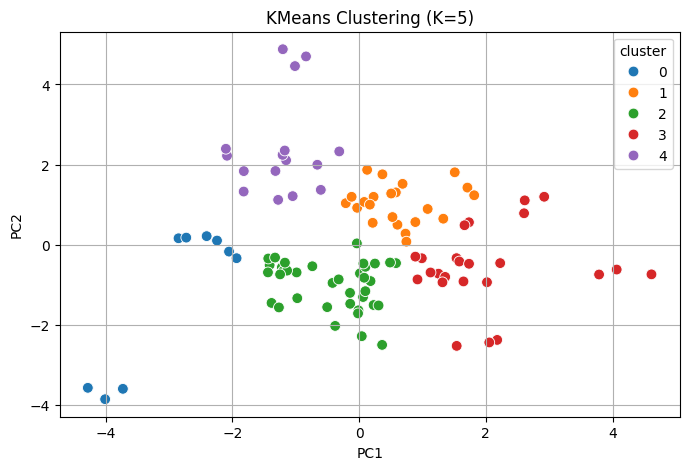


Silhouette Score (K=6): 0.4023


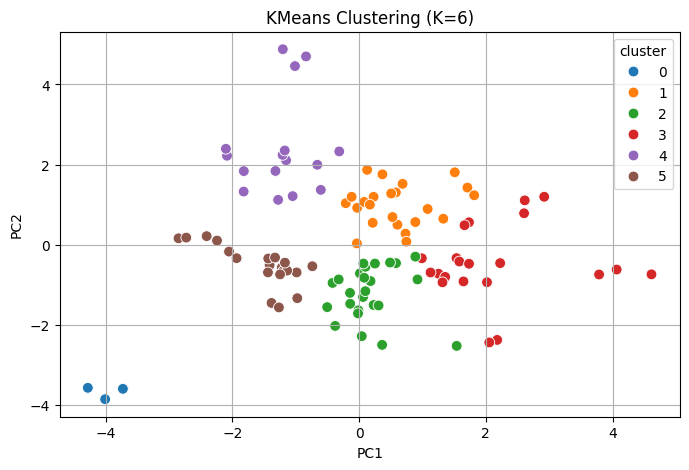


Silhouette Score (K=7): 0.3871


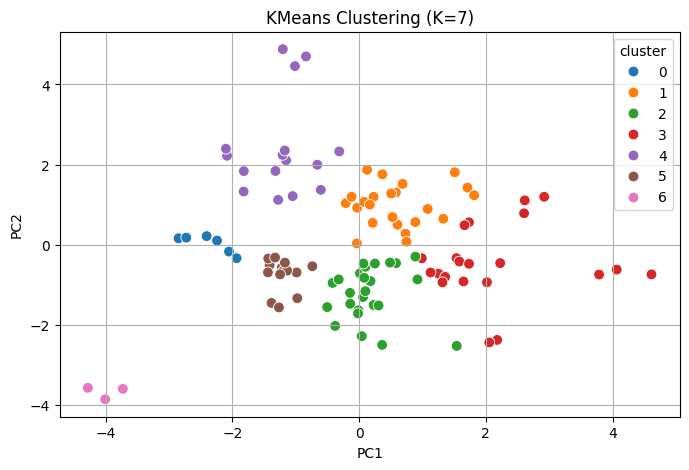

In [37]:
def run_kmeans_and_plot(pca_data, k, title):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(pca_data)
    preds = model.predict(pca_data)
    score = silhouette_score(pca_data, preds)

    pca_clustered = pca_data.copy()
    pca_clustered["cluster"] = preds

    print(f"\nSilhouette Score (K={k}): {score:.4f}")
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=pca_clustered, x='PC1', y='PC2', hue='cluster', palette='tab10', s=60)
    plt.title(title)
    plt.grid(True)
    plt.show()

    return model, pca_clustered

# Run for K = 5, 6, 7
kmeans_model_5, pca_clustered_5 = run_kmeans_and_plot(pca_data, 5, "KMeans Clustering (K=5)")
kmeans_model_6, pca_clustered_6 = run_kmeans_and_plot(pca_data, 6, "KMeans Clustering (K=6)")
kmeans_model_7, pca_clustered_7 = run_kmeans_and_plot(pca_data, 7, "KMeans Clustering (K=7)")


K=6 | Silhouette=0.4473 | DBI=0.7234 | CH=90.8159


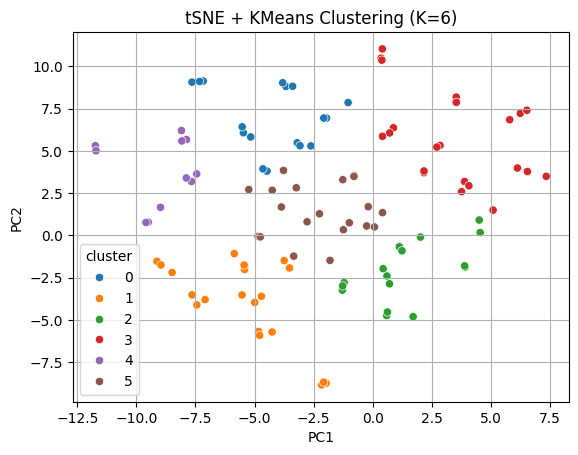

In [38]:
# 🔍 t-SNE + KMeans
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid

# Use same scaled data
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_data = pd.DataFrame(tsne.fit_transform(scaled_data), columns=["PC1", "PC2"])

k = 6
kmeans_tsne = KMeans(n_clusters=k, random_state=42)
tsne_data["cluster"] = kmeans_tsne.fit_predict(tsne_data)

# Scores
sil = silhouette_score(tsne_data, tsne_data["cluster"])
dbi = davies_bouldin_score(tsne_data, tsne_data["cluster"])
ch = calinski_harabasz_score(tsne_data, tsne_data["cluster"])
print(f"K={k} | Silhouette={sil:.4f} | DBI={dbi:.4f} | CH={ch:.4f}")

# Plot
sns.scatterplot(data=tsne_data, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title(f'tSNE + KMeans Clustering (K={k})')
plt.grid(True)
plt.show()


<ipython-input-43-7d291b1db5ac>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


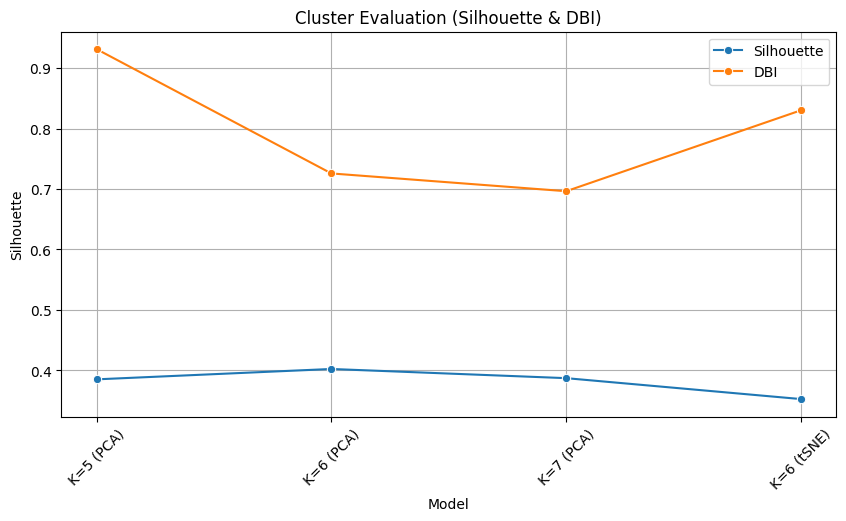

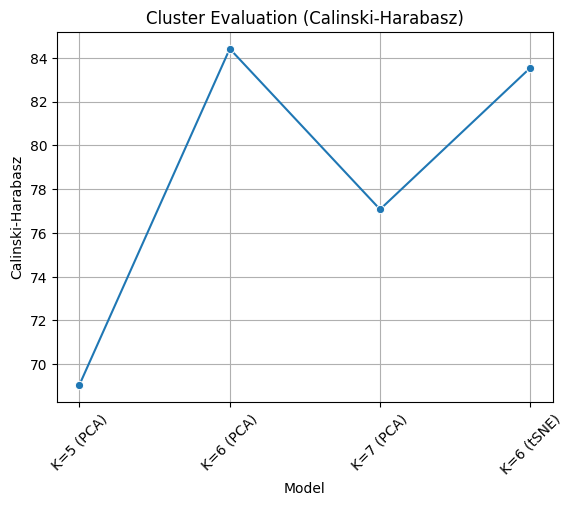

In [43]:
# 📊 Cluster Evaluation Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

models = [kmeans_model_5, kmeans_model_6, kmeans_model_7, kmeans_tsne]
model_names = ["K=5 (PCA)", "K=6 (PCA)", "K=7 (PCA)", "K=6 (tSNE)"]
metrics_df = pd.DataFrame(columns=["Model", "Silhouette", "DBI", "Calinski-Harabasz"])

for model, name in zip(models, model_names):
    # Use the appropriate data for prediction based on the model
    data_for_prediction = pca_data if name != "K=6 (tSNE)" else tsne_data
    # Only drop 'cluster' if it exists in the DataFrame
    if "cluster" in data_for_prediction.columns:
        data_for_prediction = data_for_prediction.drop(columns=["cluster"])
    labels = model.predict(data_for_prediction)
    silhouette = silhouette_score(data_for_prediction, labels)
    dbi = davies_bouldin_score(data_for_prediction, labels)
    ch = calinski_harabasz_score(data_for_prediction, labels)

    metrics_df = pd.concat([metrics_df, pd.DataFrame([{
        "Model": name,
        "Silhouette": silhouette,
        "DBI": dbi,
        "Calinski-Harabasz": ch
    }])], ignore_index=True)

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=metrics_df, x="Model", y="Silhouette", label="Silhouette", marker='o')
sns.lineplot(data=metrics_df, x="Model", y="DBI", label="DBI", marker='o')
plt.title("Cluster Evaluation (Silhouette & DBI)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

sns.lineplot(data=metrics_df, x="Model", y="Calinski-Harabasz", marker='o')
plt.title("Cluster Evaluation (Calinski-Harabasz)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [42]:
data_for_prediction

,PC1,PC2
0,0.732307,0.278651
1,-0.378193,-2.023648
2,0.013469,-0.713336
3,-1.152673,2.109208
4,1.537550,-0.333274
...,...,...
103,0.169585,1.001822
104,-2.102698,2.395347
105,3.787550,-0.741049
106,-0.322685,-0.863335
